In [33]:
import os
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from numpy import newaxis, concatenate
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error
from pandas import read_csv, DataFrame,concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential

In [34]:
def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    # divide the data into parts by seq_len, so get n matrix

    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)
    # select 90% data as training data
    row = 673
    train = result[:int(row), :]
    # random sorted training data
    #np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    # 10% as test data
    x_test = result[int(row):, : -1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalise_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalise_window)
    return normalised_data

In [35]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

In [36]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(),list()
    for i in range(n_in, 0 ,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis =1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [37]:

dataset_stock = read_csv('stock1.csv', header = 0, index_col=0)
dataset = read_csv('input.csv', header = 0, index_col=0)
values = dataset.values
values_stock = dataset_stock.values
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
values = values.astype('float32')
values_stock = values_stock.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed_stock = series_to_supervised(values_stock, 1, 1)
print(reframed.head())
print(reframed_stock.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)
1   0.240938   0.488038   0.044724  0.243070  0.435407  0.045354
2   0.243070   0.435407   0.045354  0.240938  0.617225  0.042520
3   0.240938   0.617225   0.042520  0.243070  0.401914  0.051654
4   0.243070   0.401914   0.051654  0.240938  0.559809  0.046614
5   0.240938   0.559809   0.046614  0.211087  0.397129  0.051969
   var1(t-1)  var1(t)
1     2133.0   2135.0
2     2135.0   2126.0
3     2126.0   2155.0
4     2155.0   2139.0
5     2139.0   2156.0


In [38]:
values = reframed.values
values_stock = reframed_stock.values
n_train_hours = 673
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
test_stock = values_stock[n_train_hours:, :]

train_X, train_y = train[:,:-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:,-1]
test_stock_X, test_stock_y = test_stock[:,:-1],test[:,-1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(test_stock_X, test_stock_y)

((673, 1, 5), (673,), (5, 1, 5), (5,))
(array([[ 3050.],
       [ 2992.],
       [ 2994.],
       [ 2979.],
       [ 2953.]], dtype=float32), array([ 0.31527555,  0.31590551,  0.31118107,  0.30299211,  0.3086614 ], dtype=float32))


In [39]:
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
start = time.time()
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
print("> Compilation Time :", time.time() - start)
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)


('> Compilation Time :', 0.022957801818847656)
Train on 673 samples, validate on 5 samples
Epoch 1/50
3s - loss: 0.0034 - val_loss: 1.1279e-04
Epoch 2/50
2s - loss: 0.0041 - val_loss: 1.1339e-04
Epoch 3/50
2s - loss: 0.0033 - val_loss: 7.7160e-05
Epoch 4/50
2s - loss: 0.0029 - val_loss: 7.9774e-05
Epoch 5/50
2s - loss: 0.0028 - val_loss: 8.5471e-05
Epoch 6/50
2s - loss: 0.0027 - val_loss: 6.2068e-05
Epoch 7/50
2s - loss: 0.0022 - val_loss: 8.9768e-05
Epoch 8/50
2s - loss: 0.0029 - val_loss: 8.0618e-05
Epoch 9/50
2s - loss: 0.0026 - val_loss: 4.9867e-05
Epoch 10/50
2s - loss: 0.0024 - val_loss: 8.8626e-05
Epoch 11/50
2s - loss: 0.0025 - val_loss: 1.2393e-04
Epoch 12/50
2s - loss: 0.0021 - val_loss: 1.8243e-04
Epoch 13/50
2s - loss: 0.0027 - val_loss: 2.8673e-05
Epoch 14/50
2s - loss: 0.0021 - val_loss: 1.0520e-04
Epoch 15/50
2s - loss: 0.0020 - val_loss: 1.7134e-04
Epoch 16/50
2s - loss: 0.0021 - val_loss: 3.3164e-05
Epoch 17/50
2s - loss: 0.0020 - val_loss: 1.5392e-04
Epoch 18/50
2s - 

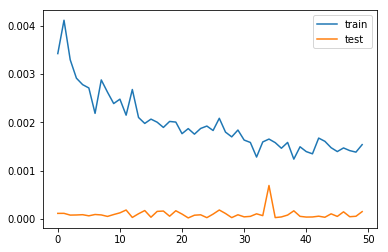

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [41]:
yhat =  model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print yhat
inv_yhat = concatenate((yhat, test_X[:,1:]), axis=1)

#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis =1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


[[ 0.3144781 ]
 [ 0.32715607]
 [ 0.32302946]
 [ 0.31535196]
 [ 0.32670045]]


Test RMSE: 0.012


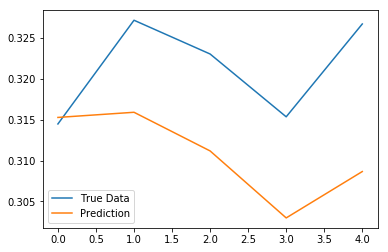

In [42]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
plot_results(inv_y, inv_yhat)

Real MSE: 0.012


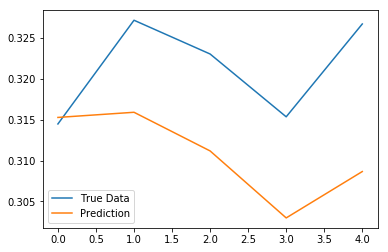

In [43]:
mse = sqrt(mean_squared_error(test_stock_y, yhat))
print('Real MSE: %.3f' % mse)
plot_results(test_stock_y, yhat)